Duration: 0 days 00:00:00.008870064
Top 3 Noisy Channels:
TDC_CHANNEL
139    860
63     499
64     491
dtype: int64


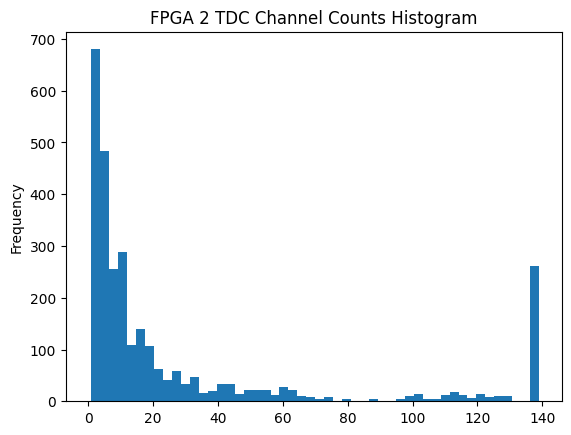

In [47]:
import matplotlib.pyplot as plt
import pandas as pd 
import os 
file_name = "./data_000637.txt" 
data = pd.read_csv(file_name) 
#row, column = data.shape  # row = 1310720 
#print(data.columns)  #'HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS' 
#print(data.info) 
#print(data.describe) 
#print(data.describe()) 
#print(data.isnull().any()) 
#print(data.dtypes) #print(type(data))  # <class 'pandas.core.frame.DataFrame'> 
#print(data.index)  # RangeIndex(start=0, stop=1310720, step=1) 

# Part 1: Create a Pandas DataFrame reading N rows
N = 10000
df = data.head(N)

# Part 2: Estimate the number of BX in an ORBIT (the value x)
max_bx = df['BX_COUNTER'].max()
x_value = max_bx + 1  # Adding 1 since BX_COUNTER starts from 0

df = df.copy()  # Make a copy of the DataFrame
# Part 3: Create a new column with absolute time in ns
df.loc[:, 'ABS_TIME_NS'] = (
    (df['ORBIT_CNT'] * x_value * 25) +
    (df['BX_COUNTER'] * 25) +
    (df['TDC_MEAS'] * (25/30))
)

# Convert the new column to a Time Series
df.loc[:, 'ABS_TIME_NS'] = pd.to_datetime(df['ABS_TIME_NS'], unit='ns')

# Part 4: Find out the duration of the data taking
duration = df['ABS_TIME_NS'].max() - df['ABS_TIME_NS'].min()
print("Duration:", duration)

# Part 5: Use the .groupby() method to find out noisy channels
noisy_channels = df.groupby('TDC_CHANNEL').size().sort_values(ascending=False)
print("Top 3 Noisy Channels:")
print(noisy_channels.head(3))

# Part 6: Count the number of non-empty orbits
non_empty_orbits = df['ORBIT_CNT'].nunique()

# Part 7: Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
unique_orbits_channel_139 = df[df['TDC_CHANNEL'] == 139]['ORBIT_CNT'].nunique()

# Part 8: Create two Series for each FPGA and TDC channel counts
fpga1_counts = df[df['FPGA'] == 1]['TDC_CHANNEL'].value_counts()
fpga2_counts = df[df['FPGA'] == 2]['TDC_CHANNEL'].value_counts()

# Part 9: Optional - Create two histograms (one for each FPGA)
df[df['FPGA'] == 1]['TDC_CHANNEL'].plot(kind='hist', bins=50, title='FPGA 1 TDC Channel Counts Histogram')
df[df['FPGA'] == 2]['TDC_CHANNEL'].plot(kind='hist', bins=50, title='FPGA 2 TDC Channel Counts Histogram')
plt.show()
